# Collision Naive Offloading
10.18.21

TJ Kim

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import pulp as lp
import itertools
import copy

In [4]:
# System Parameters
T = 1000
num_usrs = 15
num_apps = 3
num_svrs = 20
usr_app_id = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2] # Tying each user to application type

In [5]:
# Offline optimal to calculate regret
def offline_optimal_action(mu):
    
    action = np.ones_like(mu[:,0]) * -1
    
    C = np.append(mu,np.zeros([mu.shape[0],1]),axis=1)
    
    num_user = mu[:,0].shape[0]
    num_server = mu[0,:].shape[0]
    
    prob = lp.LpProblem("prob",lp.LpMaximize)
    
    # Import pulp and make decision variables
    dec_var = []
    for u,s in itertools.product(range(num_user),range(num_server+1)):
        dec_var += [(u,s-1)]

    X = lp.LpVariable.dicts("x", dec_var,lowBound=0,upBound = 1, cat='Integer')

    # Make Constraints - 1 pull per user
    usr_constraint = []
    for u in range(num_user):
        usr_constraint += [0]

    for u,s in itertools.product(range(num_user),range(num_server+1)):
        usr_constraint[u] += X[(u,s-1)]

    for u in range(num_user):
        prob += (usr_constraint[u] == 1)

    # Make constraint - 1 user per server
    svr_constraint = []

    for s in range(num_server):
        svr_constraint += [0]

    for u,s in itertools.product(range(num_user),range(num_server)):
        svr_constraint[s] += X[(u,s)]

    for s in range(num_server):
        prob += (svr_constraint[s] <= 1)

    # Make objective function
    obj = 0
    for u,s in itertools.product(range(num_user),range(num_server+1)):
        obj += C[u,s-1] * X[(u,s-1)]
    prob += obj

    status = prob.solve(lp.PULP_CBC_CMD(msg=0))
    
    X2 = copy.deepcopy(X)

    for key in X2.keys():
        if X2[key].value() > 0:
            u,s = key
            action[u] = s
    
    rwd = 0
    
    for u in range(num_user):
        rwd += C[u,int(action[u])]
    
    return action, rwd

In [6]:
# Function to decide arm availability randomly at every time step
def random_VM(num_svrs,num_apps):
    VM_deployment = np.random.randint(low=0,high=num_apps,size=num_svrs)
    return VM_deployment

# Given UCB Indices and available arms, return which arms users will pull
def UCB_postVM(VM_deployment, mu_bar, num_apps, usr_app_id):
    
    # Assign each server to each app type
    app_arms = {}
    for a in range(num_apps):
        app_arms[a] = []
    
    for s in range(len(VM_deployment)):
        vm = VM_deployment[s]
        app_arms[vm] += [s]
        
    # Assign each user to a server to offload to
    action = np.zeros_like(usr_app_id)
    
    for u in range(len(usr_app_id)):
        app_type = usr_app_id[u]
        arms = app_arms[app_type]
        mu_vals = mu_bar[u,arms]
        
        # arm_idx = np.argmax(mu_vals)
        try:
            arm_idx = np.random.choice(np.flatnonzero(mu_vals == mu_vals.max()))
            action[u] = arms[arm_idx]
        except:
            action[u] = -1 # sent to cloud is -1
        
    return action

# Optimal arm pulls for users given VM Deployment
def optimal_postVM(VM_deployment, mu_bar, num_apps, usr_app_id):
    
    action = np.ones_like(usr_app_id) * -1 # default to cloud

    # Separate each application into separate game
    usrs_by_app = {}
    svrs_by_app = {}

    for a in range(num_apps):
        usrs_by_app[a] = []
        svrs_by_app[a] = []

    for u in range(len(usr_app_id)):
        usrs_by_app[usr_app_id[u]] += [u]

    for s in range(len(VM_deployment)):
        svrs_by_app[VM_deployment[s]] += [s]

    # Loop through each application and play the game
    for a in range(num_apps):
        users = usrs_by_app[a]
        servers = svrs_by_app[a]

        C = mu_bar[users] # Cost vector including cloud
        C = mu_bar[:,servers]
        C = np.append(C,np.zeros([C.shape[0],1]),axis=1)

        prob = lp.LpProblem("prob",lp.LpMaximize)

        # Import pulp and make decision variables
        dec_var = []
        for u,s in itertools.product(users,servers+[-1]):
            dec_var += [(u,s)]

        X = lp.LpVariable.dicts("x", dec_var,lowBound=0,upBound = 1, cat='Integer')

        # Make Constraints - 1 pull per user
        usr_constraint = []
        for u in users:
            usr_constraint += [0]

        for ui,s in itertools.product(range(len(users)),servers+[-1]):
            usr_constraint[ui] += X[(users[ui],s)]

        for ui in range(len(users)):
            prob += (usr_constraint[ui] == 1)

        # Make constraint - 1 user per server
        svr_constraint = []

        for s in servers:
            svr_constraint += [0]

        for u,si in itertools.product(users,range(len(servers))):
            svr_constraint[si] += X[(u,servers[si])]

        for si in range(len(servers)):
            prob += (svr_constraint[si] <= 1)

        # Make objective function
        obj = 0
        for ui,si in itertools.product(range(len(users)), range(len(servers+[-1]))):
            u, s= users[ui], (servers+[-1])[si]
            obj += C[ui,si] * X[(u,s)]
        prob += obj

        status = prob.solve(lp.PULP_CBC_CMD(msg=0))

        X2 = copy.deepcopy(X)

        for key in X2.keys():
            if X2[key].value() > 0:
                u,s = key
                action[u] = s
        
        
    return action

# Optimal arm pulls with optimal VM deployment (P1 solution)
def online_VM(mu_bar, num_rounds, num_apps, usr_app_id):
    
    VM_deployment = np.zeros_like(mu_bar[0,:])

    # Separate each application into separate game
    usrs_by_app = {}

    for a in range(num_apps):
        usrs_by_app[a] = []

    for u in range(len(usr_app_id)):
        usrs_by_app[usr_app_id[u]] += [u]

    # Initialize to highest reward -- assume no collision + offload to all
    rwds_per_svr = np.zeros([num_apps,mu_bar[0,:].shape[0]])
    for a in range(num_apps):
        rwds_per_svr[a] = np.sum(mu_bar[usrs_by_app[a]],axis=0)

    for s in range(mu_bar[0,:].shape[0]):
        VM_deployment[s] = np.random.choice(np.flatnonzero(rwds_per_svr[:,s] == rwds_per_svr[:,s].max()))

    for t in range(T):
        # Calculate reward associated with each server (argmax)
        rwd_s = exp_rwd_per_svr(mu_bar, VM_deployment, num_apps, usr_app_id)
        s_order = np.argsort(rwd_s) # Order servers from lowest to highest reward per user

        # From lowest server upward, perform swaps of VMs to other apps and stick w app with highest global reward
        for s in s_order:
            VM_deployment = VM_swapping(VM_deployment, s, num_apps,mu_bar,usr_app_id)
    
    return VM_deployment

# Function to get expected reward per server given mu_bar and VM_deployment
def exp_rwd_per_svr(mu_bar, VM_deployment, num_apps, usr_app_id):
    
    # Separate each application into separate game
    svrs_by_app = {}

    for a in range(num_apps):
        svrs_by_app[a] = []

    for s in range(len(VM_deployment)):
        svrs_by_app[VM_deployment[s]] += [s]
    
    for s in range(len(VM_deployment)):
        svrs_by_app[VM_deployment[s]] += [s]

    action = UCB_postVM(VM_deployment, mu_bar, num_apps, usr_app_id)

    num_servers = mu_bar.shape[1]
    rwd_s = np.zeros(num_servers)

    for s in range(num_servers):
        users_pulling_server = np.where(action == s)[0]
        mus = mu_bar[users_pulling_server]
        mus = mus[:,s]

        if mus.shape[0]>0:
            rwd_s[s] = np.mean(mus)/users_pulling_server.shape[0]
        else:
            rwd_s[s] = 0
    
    return rwd_s

def VM_swapping(VM_deployment, s_idx, num_apps,mu_bar,usr_app_id):
    
    VM_deployment = copy.deepcopy(VM_deployment)
    base_rwd = np.sum(exp_rwd_per_svr(mu_bar, VM_deployment, num_apps, usr_app_id))
    
    for a in range(num_apps):
        VM_temp = copy.deepcopy(VM_deployment)
        VM_temp[s_idx] = a 
        new_rwd = np.sum(exp_rwd_per_svr(mu_bar, VM_temp, num_apps, usr_app_id))
        
        if new_rwd > base_rwd:
            base_rwd = new_rwd
            VM_deployment = VM_temp
    
    return VM_deployment

In [ ]:
# Set Arm Parameters for every user - arm pair (randomly draw)
mu = np.random.rand(num_usrs,num_svrs)

mu_hat1 = np.ones_like(mu) # empirical mean
mu_hat2 = np.ones_like(mu)
mu_hat3 = np.ones_like(mu)

T_ka1 = np.ones_like(mu) # total number of times arm (k,a) is played
T_ka2 = np.ones_like(mu) 
T_ka3 = np.ones_like(mu) 

reg1 = np.zeros(T) # regret
reg2 = np.zeros(T) 
reg3 = np.zeros(T)

rwd1 = np.zeros(T) # reward
rwd2 = np.zeros(T) 
rwd3 = np.zeros(T) 

collision1 = np.zeros(T)
collision2 = np.zeros(T)
collision3 = np.zeros(T)

opt_num_rounds = 5

action_opt, opt_rwd = offline_optimal_action(mu)

# Run T Round of UCB1 Algorithm
for t in range(T):
    print(t)
    rho_ka1 = np.sqrt(2*np.log(t+1)/(2*T_ka1))
    rho_ka2 = np.sqrt(2*np.log(t+1)/(2*T_ka2))
    rho_ka3 = np.sqrt(2*np.log(t+1)/(2*T_ka3))
    
    mu_bar1 = np.minimum(mu_hat1 + rho_ka1, 1) # UCB
    mu_bar2 = np.minimum(mu_hat2 + rho_ka2, 1) 
    mu_bar3 = np.minimum(mu_hat3 + rho_ka3, 1)
    
    VM_deployment = random_VM(num_svrs,num_apps)
    VM_deployment_online = online_VM(mu_bar2, opt_num_rounds, num_apps, usr_app_id)
    
    action1 = UCB_postVM(VM_deployment,mu_bar1,num_apps,usr_app_id)
    action2 = UCB_postVM(VM_deployment_online,mu_bar2,num_apps,usr_app_id)
    action3, _ = offline_optimal_action(mu_bar3)

    # Count number of times sent to cloud
    
    # Hand out rewards (given collisions) -- loop through servers
    for s in range(num_svrs):
        s_usrs =  np.where((action1 == s)>0)[0] # list of users who pulled this server
        
        if s_usrs.shape[0] > 0: 
            r_user = np.random.choice(s_usrs)# randomly select 1 user to give reward to (all other 0)
            X_k = int(np.random.rand() < mu[r_user, s])
            rwd1[t] += X_k
            
            # Record Collision
            if s_usrs.shape[0] > 1:
                collision1[t] += s_usrs.shape[0] - 1
            
            # Update T_ka for all users of this arm
            for u in s_usrs:
                T_ka1[u,s] += 1
                if u == r_user:
                    mu_hat1[u, s] += (X_k - mu_hat1[u, s]) / T_ka1[u, s]
                else:
                    mu_hat1[u, s] += (0 - mu_hat1[u, s]) / T_ka1[u, s]
                    
    # Hand out rewards (given post vm optimal) -- loop through servers
    for s in range(num_svrs):
        s_usrs =  np.where((action2 == s)>0)[0] # list of users who pulled this server
        
        if s_usrs.shape[0] > 0: 
            r_user = np.random.choice(s_usrs)# randomly select 1 user to give reward to (all other 0)
            X_k = int(np.random.rand() < mu[r_user, s])
            rwd2[t] += X_k
            
            # Record Collision
            if s_usrs.shape[0] > 1:
                collision2[t] += s_usrs.shape[0] - 1
            
            # Update T_ka for all users of this arm
            for u in s_usrs:
                T_ka2[u,s] += 1
                if u == r_user:
                    mu_hat2[u, s] += (X_k - mu_hat2[u, s]) / T_ka2[u, s]
                else:
                    mu_hat2[u, s] += (0 - mu_hat2[u, s]) / T_ka2[u, s]
                    
    # Hand out rewards centralized MAB
    for s in range(num_svrs):
        s_usrs =  np.where((action3 == s)>0)[0] # list of users who pulled this server
        
        if s_usrs.shape[0] > 0: 
            r_user = np.random.choice(s_usrs)# randomly select 1 user to give reward to (all other 0)
            X_k = int(np.random.rand() < mu[r_user, s])
            rwd3[t] += X_k
            
            # Record Collision
            if s_usrs.shape[0] > 1:
                collision3[t] += s_usrs.shape[0] - 1
            
            # Update T_ka for all users of this arm
            for u in s_usrs:
                T_ka3[u,s] += 1
                if u == r_user:
                    mu_hat3[u, s] += (X_k - mu_hat3[u, s]) / T_ka3[u, s]
                else:
                    mu_hat3[u, s] += (0 - mu_hat3[u, s]) / T_ka3[u, s]

    reg1[t] = opt_rwd*t - np.sum(rwd1[0:t])
    reg2[t] = opt_rwd*t - np.sum(rwd2[0:t])
    reg3[t] = opt_rwd*t - np.sum(rwd3[0:t])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

plt.plot(range(T),reg1,label="Collision naive")
plt.plot(range(T),reg2,label='Smart VM Placement')
plt.plot(range(T),reg3,label='Central MAB')
plt.legend()
plt.xlabel('Rounds (t)')
plt.ylabel('Regret')
plt.title('Comparison of Different MAB Approach')

Text(0.5,1,'Comparison of Different MAB Approach')

/home/tkim/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


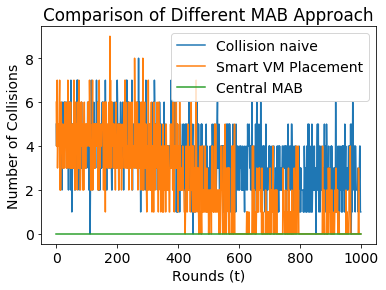

In [7]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

plt.plot(range(T),collision1,label="Collision naive")
plt.plot(range(T),collision2,label='Smart VM Placement')
plt.plot(range(T),collision3,label='Central MAB')
plt.legend()
plt.xlabel('Rounds (t)')
plt.ylabel('Number of Collisions')
plt.title('Comparison of Different MAB Approach')

In [19]:
# Find differences between consecutive regrets
reg1_delta = [j-i for i, j in zip(reg1[:-1], reg1[1:])] 
reg2_delta = [j-i for i, j in zip(reg2[:-1], reg2[1:])] 
reg3_delta = [j-i for i, j in zip(reg3[:-1], reg3[1:])] 

print("reg1", np.mean(reg1_delta[-200:-1]))
print("reg2", np.mean(reg2_delta[-200:-1]))
print("reg3", np.mean(reg3_delta[-200:-1]))

# print("reg1", (reg1_delta[-50:-1]))
# print("reg2", (reg2_delta[-50:-1]))
# print("reg3", (reg3_delta[-50:-1]))


reg1 4.164656576626497
reg2 1.1847570791390596
reg3 1.5616415012496123
